# `WDM` on zf

# running `WDM` on zf

## imports

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
!pip install scanpy -q

In [70]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [71]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [72]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [74]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [75]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]


Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks

In [76]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]
# exclude_rows = [1099, None, None, 325, None, None]

## load features and spatial coords specific to the triple

In [77]:
s0_name = zf_names[0]
s1_name = zf_names[1]
s2_name = zf_names[2]
s3_name = zf_names[3]
s4_name = zf_names[4]
s5_name = zf_names[5]


filehandle_pair0 = filehandle_zf + 'pair' + str(0) + '/'
filehandle_pair1 = filehandle_zf + 'pair' + str(1) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(2) + '/'
filehandle_pair3 = filehandle_zf + 'pair' + str(3) + '/'
filehandle_pair4 = filehandle_zf + 'pair' + str(4) + '/'


X0 = np.load(filehandle_pair0 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair3 + s3_name + '_feature.npy')
X4 = np.load(filehandle_pair4 + s4_name + '_feature.npy')
X5 = np.load(filehandle_pair4 + s5_name + '_feature.npy')

Xs = [X0, X1, X2, X3, X4, X5]

## form cost matrices

In [78]:
C12_np = cdist(X1, X2)
C23_np = cdist(X2, X3)

'''
A11_np = cdist(S1, S1)
A22_np = cdist(S2, S2)
A33_np = cdist(S3, S3)
''';

In [79]:
C12 = torch.from_numpy(C12_np).to(device)
C23 = torch.from_numpy(C23_np).to(device)

'''
A11 = torch.from_numpy(A11_np).to(device)
A22 = torch.from_numpy(A22_np).to(device)
A33 = torch.from_numpy(A33_np).to(device)
''';

## alternate idea for cost matrices

In [80]:
# code now in util_zf.py
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

## set truncation, time

In [81]:
## set truncation
truncation = 50
time = 20.0

## make HDM representation of each slice

## overriding old cost matrices

In [82]:
%%time
Aiis_np = []

for i, X in enumerate(Xs):
    X_HDM = util_zf.HDM_from_XS(spatial_list[i], X, truncation=truncation, time=time)
    Aii_HDM_np = cdist(X_HDM, X_HDM)
    Aiis_np += [Aii_HDM_np]


Aiis = [torch.from_numpy(Aii).to(device) for Aii in Aiis_np]

CPU times: user 2min 41s, sys: 1min 39s, total: 4min 21s
Wall time: 29.2 s


## factor cost matrices

In [83]:
importlib.reload(util_zf)


<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [84]:
rank_list = [(3,7),(7,7),(7,11),(11,14),(14,19)]
#exclude_rows = [1099, None, None, 325, None, None]

C_factors_sequence = []
A_factors_sequence = []

for i in range(len(rank_list)):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Loading slices {s1_name} to {s2_name}')

    r1, r2 = rank_list[i]
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]

    filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
    save_dir = filehandle_pair
    C_matrix = cdist(Xs[i], Xs[i+1])
    C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C_matrix, Aiis[i].cpu().numpy(), Aiis[i+1].cpu().numpy(), \
                                                    device, z=50, c=100, nidx_1=nidx_1, nidx_2=nidx_2)
    C_factors_sequence.append(C_factors12)
    if i == 0:
        A_factors_sequence.append(A_factors11)
        A_factors_sequence.append(A_factors22)
    else:
        A_factors_sequence.append(A_factors22)




c = max([torch.max(C[0] @ C[1]) for C in C_factors_sequence])
c = max(c, 1/c)
for i in range(len(C_factors_sequence)):
    C = C_factors_sequence[i]
    C_factors_sequence[i] = (C[0]/c, C[1]/c)

Loading slices zf3 to zf5
C done
A done
B done
Loading slices zf5 to zf10
C done
A done
B done
Loading slices zf10 to zf12
C done
A done
B done
Loading slices zf12 to zf18
C done
A done
B done
Loading slices zf18 to zf24
C done
A done
B done


## set OT hyperparameters

In [85]:
gamma=500
tau_out=1e4
tau_in=5e-8
alpha = 0.1
beta = 0.0

max_iter=100
min_iter=100

## run `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.938933187828413e-09, GW-cost: 9.219155203651337e-69, Total cost: 3.5450398690455717e-09
Final Wasserstein cost: 3.5093473755300913e-09, GW-cost: 9.432487013403174e-69, Total cost: 3.158412637977082e-09


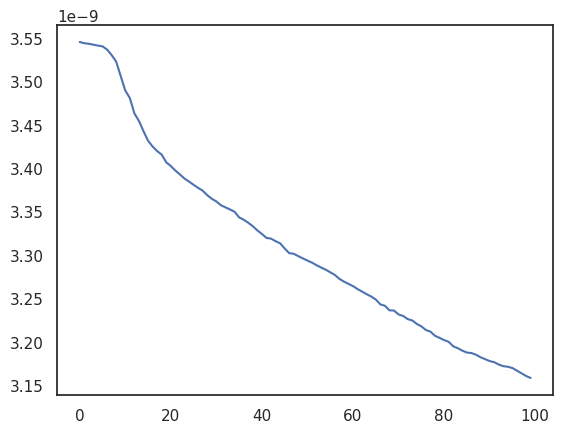

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 4.141819043657074e-09, GW-cost: 9.432487013348806e-69, Total cost: 3.727637139291367e-09
Final Wasserstein cost: 3.974938971307706e-09, GW-cost: 9.43248701334757e-69, Total cost: 3.577445074176935e-09


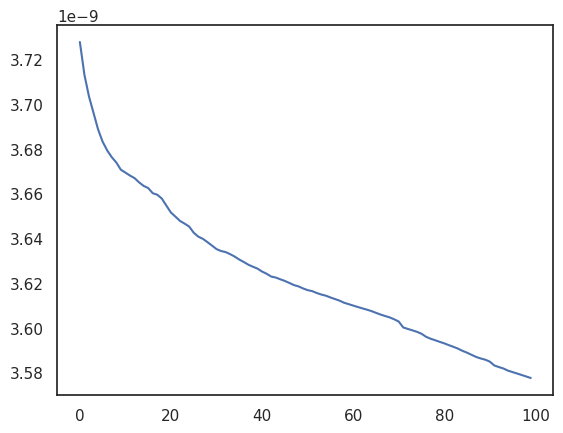

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.829716391692918e-09, GW-cost: 5.137386719628053e-91, Total cost: 2.5467447525236264e-09
Final Wasserstein cost: 2.5837795315564596e-09, GW-cost: 5.137386719628053e-91, Total cost: 2.3254015784008136e-09


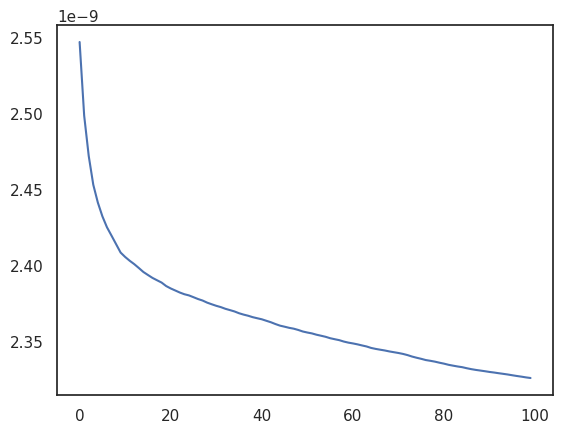

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.0832781504453614e-09, GW-cost: 2.938822117914284e-136, Total cost: 2.7749503354008254e-09
Final Wasserstein cost: 2.861130008380002e-09, GW-cost: 2.952616805911706e-136, Total cost: 2.575017007542002e-09


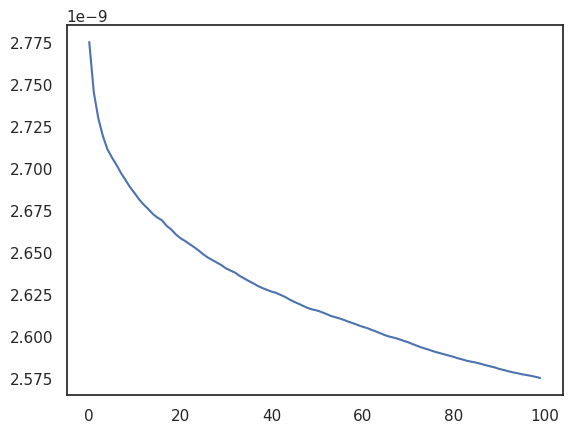

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.446737653688688e-09, GW-cost: 5.095491265470947e-138, Total cost: 3.1020638883198193e-09
Final Wasserstein cost: 2.6036950880875876e-09, GW-cost: 5.214822990739459e-138, Total cost: 2.343325579278829e-09


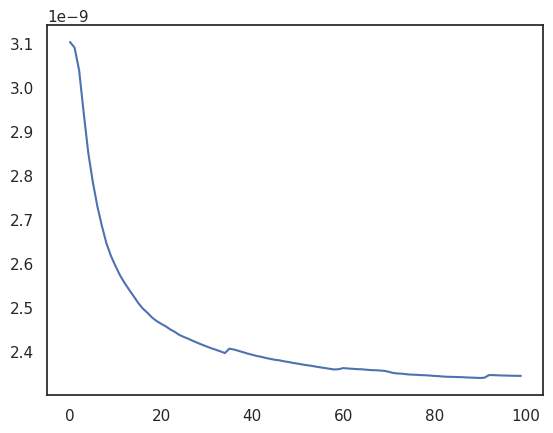

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.0989907698962746e-09, GW-cost: 2.8092161419256446e-136, Total cost: 2.789091692906647e-09
Final Wasserstein cost: 2.756212102339983e-09, GW-cost: 2.541609077326876e-136, Total cost: 2.4805908921059845e-09


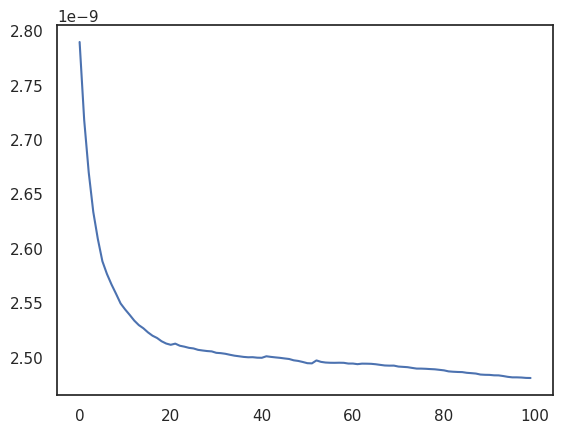

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.5845465928974963e-09, GW-cost: 5.044529932769959e-91, Total cost: 2.326091933607747e-09
Final Wasserstein cost: 2.3986702713260215e-09, GW-cost: 5.170168582937874e-91, Total cost: 2.1588032441934194e-09


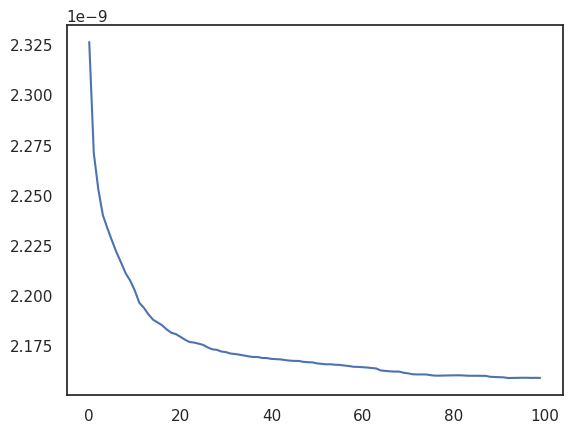

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.957654922356193e-09, GW-cost: 9.125268258524208e-69, Total cost: 3.5618894301205737e-09
Final Wasserstein cost: 3.8045007561369726e-09, GW-cost: 8.336543211554258e-69, Total cost: 3.4240506805232754e-09


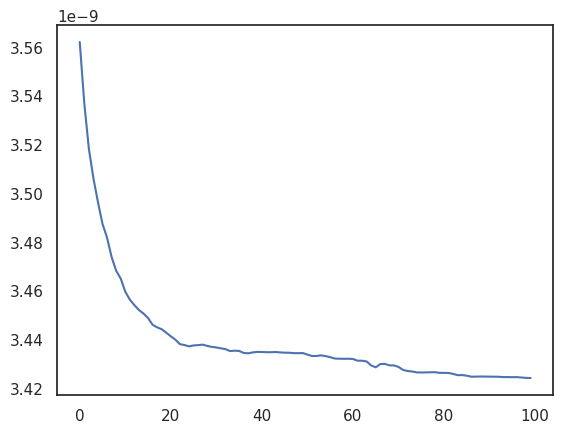

Ranks: r1 3, r2 7, r3 7
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 7.866117338640462e-09
Final Wasserstein-sum cost: 7.600256294726779e-09


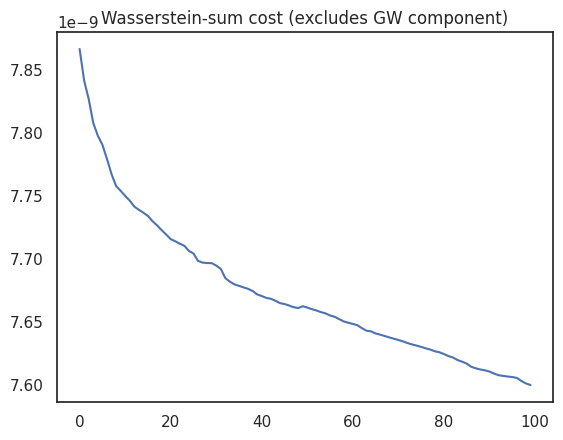

Ranks: r1 7, r2 7, r3 11
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.80470928176805e-09
Final Wasserstein-sum cost: 6.376075143523331e-09


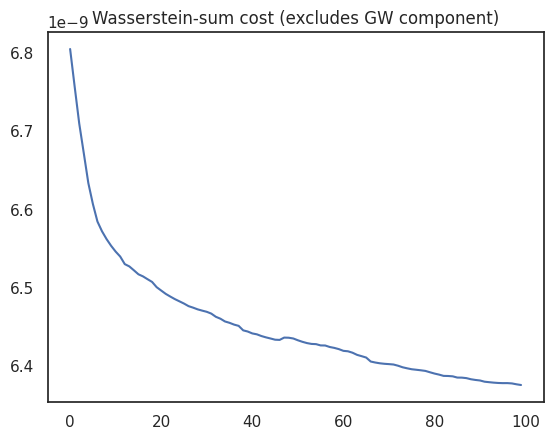

Ranks: r1 7, r2 11, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 5.981178180668668e-09
Final Wasserstein-sum cost: 5.372122514084989e-09


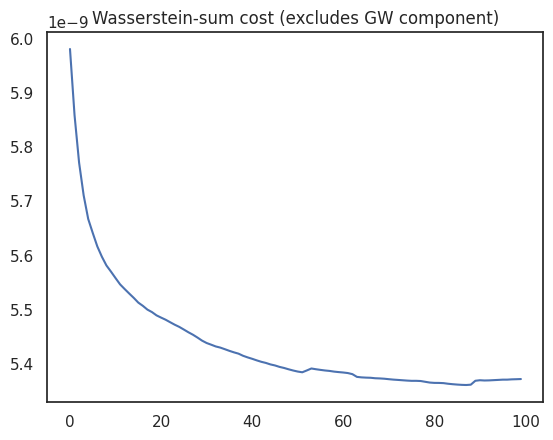

Ranks: r1 11, r2 14, r3 19
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.148977755106246e-09
Final Wasserstein-sum cost: 5.5672299603968505e-09


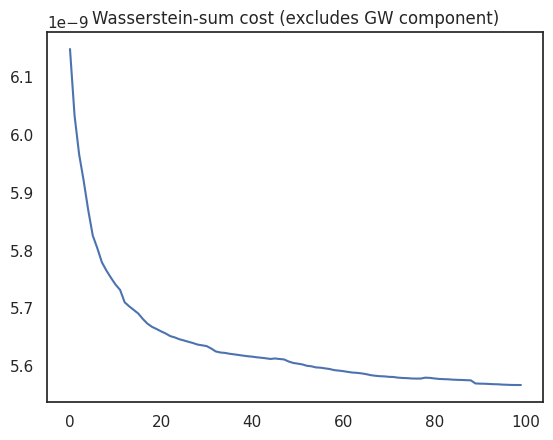

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.764516653461867e-09, GW-cost: 8.437083531395875e-69, Total cost: 3.3880649881156806e-09
Final Wasserstein cost: 3.7080922125518215e-09, GW-cost: 8.437083531395875e-69, Total cost: 3.3372829912966393e-09


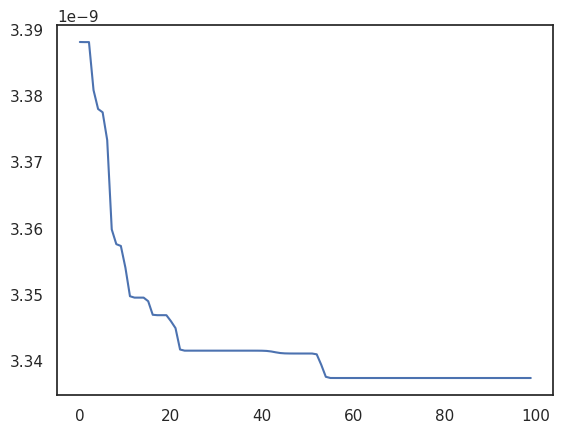

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.956247114344528e-09, GW-cost: 8.437083531343719e-69, Total cost: 3.560622402910075e-09
Final Wasserstein cost: 3.811020000121304e-09, GW-cost: 8.437083531342968e-69, Total cost: 3.429918000109174e-09


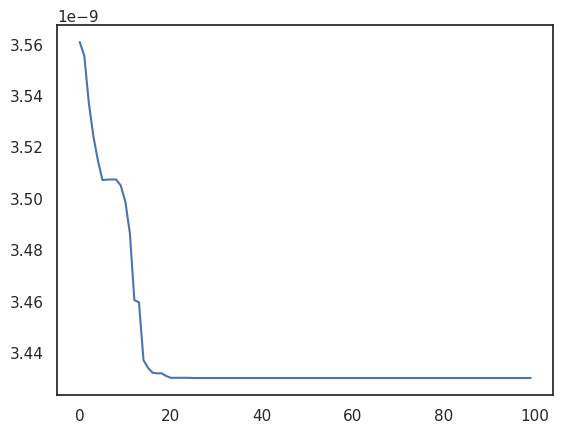

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.5677386266036617e-09, GW-cost: 5.550359448498381e-91, Total cost: 2.3109647639432955e-09
Final Wasserstein cost: 2.4536213618029687e-09, GW-cost: 5.550359448498381e-91, Total cost: 2.208259225622672e-09


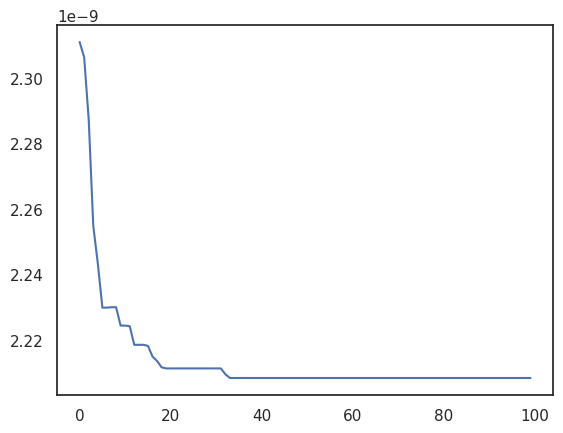

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.0820564501124086e-09, GW-cost: 2.590350137426654e-136, Total cost: 2.773850805101168e-09
Final Wasserstein cost: 2.863564903094605e-09, GW-cost: 2.642489584924257e-136, Total cost: 2.5772084127851446e-09


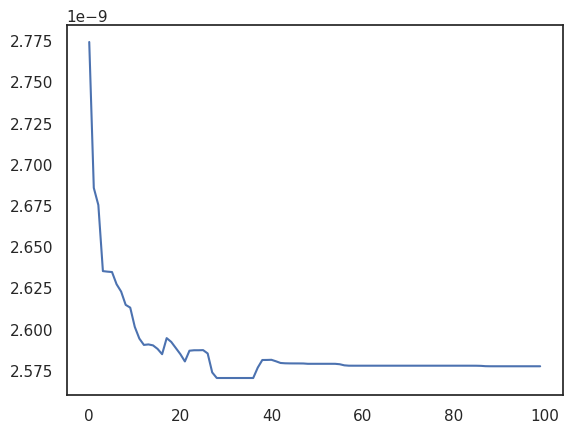

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.05533782009553e-09, GW-cost: 5.297726417066832e-138, Total cost: 2.7498040380859772e-09
Final Wasserstein cost: 2.6586181110591243e-09, GW-cost: 5.297726417066863e-138, Total cost: 2.3927562999532117e-09


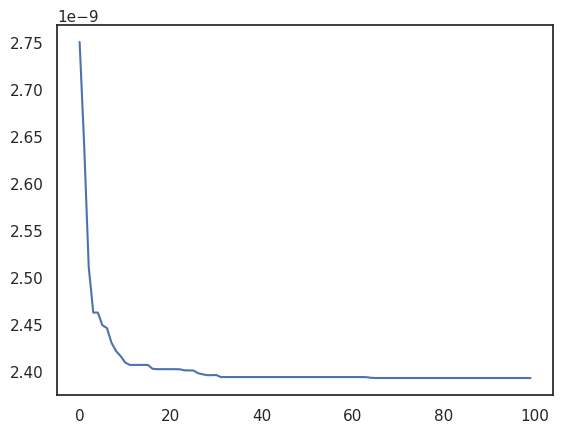

CPU times: user 5min 13s, sys: 3.61 s, total: 5min 16s
Wall time: 5min 12s


In [86]:
%%time
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(rank_list, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

Qs_pred = [Q.cpu().numpy() for Q in WDM.Q_gammas]
Ts_pred = [T.cpu().numpy() for T in WDM.T_gammas]

In [87]:
Ss = spatial_list

node_labels1 = [None for Q in WDM.Q_gammas]

clustering.plot_clusters_from_QT(Ss, Qs_pred, Ts_pred, node_labels1)
clustering.diffmap_from_QT(Qs_pred, Ts_pred, cell_type_labels=node_labels1)

Output hidden; open in https://colab.research.google.com to view.

## save

In [88]:
for i,Q in enumerate(WDM.Q_gammas):
    np.save(filehandle_save + f'wdm_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM.T_gammas):
    np.save(filehandle_save + f'wdm_T{i}{i+1}.npy', T.cpu().numpy())

## ari, ami

In [136]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [137]:
gt_types_list = clustering.max_likelihood_clustering(Qs_gt)
pred_types_list = clustering.max_likelihood_clustering(Qs_pred)

util_zf.compute_ARI_and_AMI(gt_types_list, pred_types_list)

ARI and AMI of predictions (filtered excludes ground truth clusters smaller than 5% of the data)

ARI for 0th slice is 0.175 (filtered: 0.175) 	
AMI for 0th slice is 0.182 (filtered: 0.182)


ARI for 1th slice is 0.307 (filtered: 0.325) 	
AMI for 1th slice is 0.227 (filtered: 0.257)


ARI for 2th slice is 0.157 (filtered: 0.163) 	
AMI for 2th slice is 0.167 (filtered: 0.172)


ARI for 3th slice is 0.076 (filtered: 0.085) 	
AMI for 3th slice is 0.207 (filtered: 0.199)


ARI for 4th slice is 0.213 (filtered: 0.209) 	
AMI for 4th slice is 0.315 (filtered: 0.288)


ARI for 5th slice is 0.233 (filtered: 0.239) 	
AMI for 5th slice is 0.451 (filtered: 0.458)




In [89]:


print(f"ARI of predictions \n")
for i in range(len(Qs_gt)):
    print(f"ari of predictions, slice {i}: {ari(gt_types_list[i], pred_types_list[i]):.3f}")

print('\n')
print(f"AMI of predictions \n")
for i in range(len(Qs_gt)):
    print(f"ami of predictions, slice {i}: {ami(gt_types_list[i], pred_types_list[i]):.3f}")


ARI of predictions 

ari of predictions, slice 0: 0.175
ari of predictions, slice 1: 0.307
ari of predictions, slice 2: 0.157
ari of predictions, slice 3: 0.076
ari of predictions, slice 4: 0.213
ari of predictions, slice 5: 0.233


AMI of predictions 

ami of predictions, slice 0: 0.182
ami of predictions, slice 1: 0.227
ami of predictions, slice 2: 0.167
ami of predictions, slice 3: 0.207
ami of predictions, slice 4: 0.315
ami of predictions, slice 5: 0.451


In [116]:
# Set the threshold percentage
x = 5.0  # Exclude clusters smaller than 1% of the data

print(f"ARI and AMI of predictions (excluding ground truth clusters smaller than {x}% of the data)\n")
for i in range(len(Qs_gt)):
    gt_labels = np.array(gt_types_list[i])
    pred_labels = np.array(pred_types_list[i])
    total_points = len(gt_labels)

    # Compute counts of ground truth clusters
    unique_labels, counts = np.unique(gt_labels, return_counts=True)
    percentages = counts / total_points * 100

    # Identify clusters to keep (clusters with size >= x%)
    clusters_to_keep = unique_labels[percentages >= x]

    # Create a mask to keep only data points in clusters_to_keep
    mask = np.isin(gt_labels, clusters_to_keep)

    # Apply mask to both gt_labels and pred_labels
    gt_labels_filtered = gt_labels[mask]
    pred_labels_filtered = pred_labels[mask]

    # Compute ARI and AMI on the filtered labels
    ari_score = ari(gt_labels_filtered, pred_labels_filtered)
    ami_score = ami(gt_labels_filtered, pred_labels_filtered)

    print(f"Slice {i}: ARI = {ari_score:.3f}, AMI = {ami_score:.3f}")

ARI and AMI of predictions (excluding ground truth clusters smaller than 5.0% of the data)

Slice 0: ARI = 0.175, AMI = 0.182
Slice 1: ARI = 0.325, AMI = 0.257
Slice 2: ARI = 0.163, AMI = 0.172
Slice 3: ARI = 0.085, AMI = 0.199
Slice 4: ARI = 0.209, AMI = 0.288
Slice 5: ARI = 0.239, AMI = 0.458


## freezing $Q$s with annotations, running `WDM`

In [90]:
rank_list

[(3, 7), (7, 7), (7, 11), (11, 14), (14, 19)]

In [91]:
len(Qs_gt_tensor)

6

In [92]:
Qs_gt_tensor[-1].shape

torch.Size([5271, 19])

In [93]:
A_factors_sequence[5][1].shape

torch.Size([50, 5271])

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.9541957622087554e-09, GW-cost: 9.188865714539524e-69, Total cost: 3.55877618598788e-09
Final Wasserstein cost: 3.9156492139722344e-09, GW-cost: 9.188865714539524e-69, Total cost: 3.524084292575011e-09


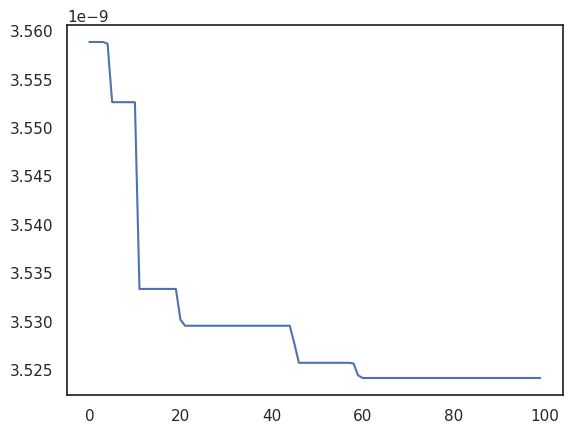

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 4.0271093561254416e-09, GW-cost: 9.188865714492637e-69, Total cost: 3.6243984205128975e-09
Final Wasserstein cost: 4.015446920066127e-09, GW-cost: 9.188865714486613e-69, Total cost: 3.6139022280595144e-09


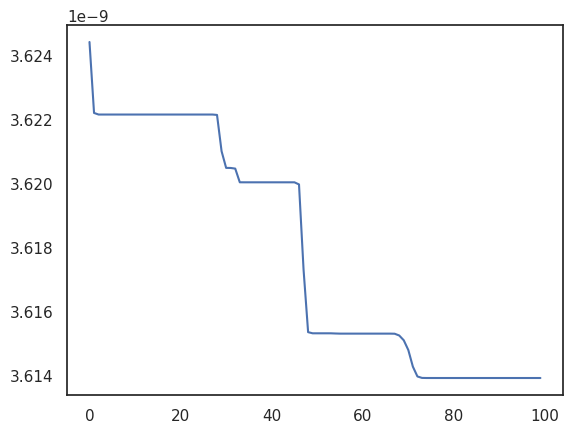

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.9176542316668378e-09, GW-cost: 5.009469868438545e-91, Total cost: 2.6258888085001542e-09
Final Wasserstein cost: 2.750449612107625e-09, GW-cost: 5.009469868438545e-91, Total cost: 2.4754046508968625e-09


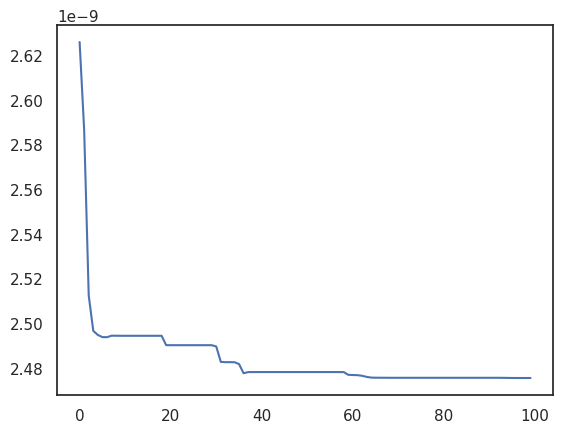

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.210887399799176e-09, GW-cost: 2.7724239186129593e-136, Total cost: 2.8897986598192585e-09
Final Wasserstein cost: 3.133726710232542e-09, GW-cost: 2.86451168386221e-136, Total cost: 2.820354039209288e-09


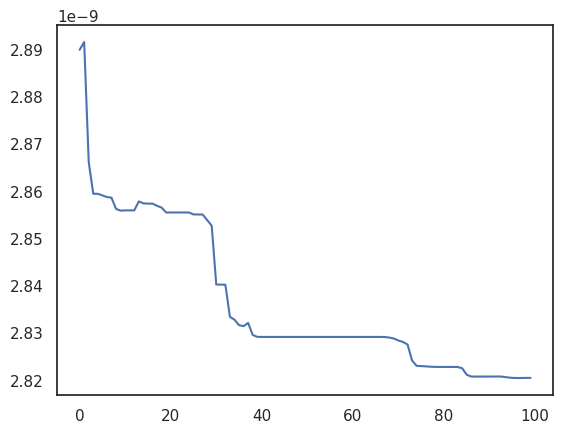

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.3691871923744936e-09, GW-cost: 5.0974064649076254e-138, Total cost: 3.0322684731370443e-09
Final Wasserstein cost: 3.112591778401453e-09, GW-cost: 5.0974064649076665e-138, Total cost: 2.801332600561308e-09


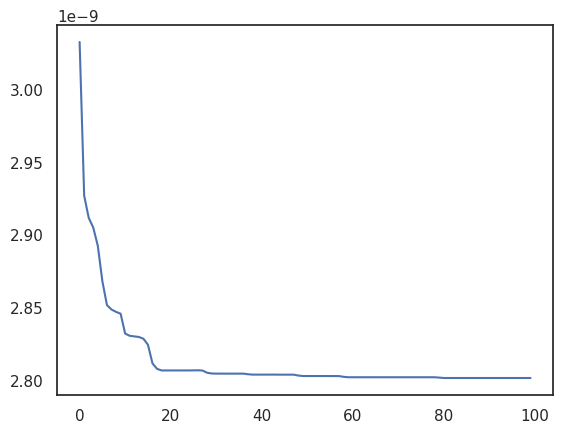

CPU times: user 1min 8s, sys: 1.08 s, total: 1min 9s
Wall time: 1min 8s


In [94]:
%%time
Q_annot = Qs_gt_tensor

importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=100, min_iter=100, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args=None)

WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)
T_gammas = WDM2.T_gammas

In [95]:
for i,Q in enumerate(WDM2.Q_gammas):
    np.save(filehandle_save + f'ann_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM2.T_gammas):
    np.save(filehandle_save + f'ann_T{i}{i+1}.npy', T.cpu().numpy())

# Analysis part 1: entropy of transitions

In [96]:
Ts_ann = T_gammas
Ts_pred = Ts_pred

## entropy functions

In [108]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [109]:
util_zf.compare_T_entropies(Ts_ann, Ts_pred)

The entropy of anno transitions from 0 to 1 is 1.846
The entropy of pred transitions from 0 to 1 is 2.098
Pred transitions from 0 to 1 are **less* entropic than anno transitions


The entropy of anno transitions from 1 to 2 is 2.271
The entropy of pred transitions from 1 to 2 is 2.280
Pred transitions from 1 to 2 are **less* entropic than anno transitions


The entropy of anno transitions from 2 to 3 is 2.383
The entropy of pred transitions from 2 to 3 is 2.548
Pred transitions from 2 to 3 are **less* entropic than anno transitions


The entropy of anno transitions from 3 to 4 is 2.696
The entropy of pred transitions from 3 to 4 is 2.962
Pred transitions from 3 to 4 are **less* entropic than anno transitions


The entropy of anno transitions from 4 to 5 is 2.942
The entropy of pred transitions from 4 to 5 is 3.177
Pred transitions from 4 to 5 are **less* entropic than anno transitions




In [110]:
util_zf.compare_T_col_entropies(Ts_ann, Ts_pred)

The column entropy of anno transitions from 0 to 1 is 0.935
The column entropy of pred transitions from 0 to 1 is 2.098
Pred transitions from 0 to 1 have **less* column entropy than anno transitions


The column entropy of anno transitions from 1 to 2 is 2.315
The column entropy of pred transitions from 1 to 2 is 2.280
Pred transitions from 1 to 2 have **more** column entropy than anno transitions


The column entropy of anno transitions from 2 to 3 is 1.572
The column entropy of pred transitions from 2 to 3 is 2.548
Pred transitions from 2 to 3 have **less* column entropy than anno transitions


The column entropy of anno transitions from 3 to 4 is 3.461
The column entropy of pred transitions from 3 to 4 is 2.962
Pred transitions from 3 to 4 have **more** column entropy than anno transitions


The column entropy of anno transitions from 4 to 5 is 5.347
The column entropy of pred transitions from 4 to 5 is 3.177
Pred transitions from 4 to 5 have **more** column entropy than anno transi

# Analysis part 2: DE analysis

## load output of `WDM`

In [ ]:
wdm_Qs = []
wdm_Ts = []


wdm_Q0 = np.load(filehandle_save + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_save + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_save + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_save + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_save + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_save+ 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_save + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_save + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_save + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_save + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_save + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_save + 'ann_T0.npy')
ann_T1 = np.load(filehandle_save + 'ann_T1.npy')

### lists of these for the three cases

Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]

Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

Qs_wdm = [wdm_Q0, wdm_Q1, wdm_Q2]
Ts_wdm = [wdm_T0, wdm_T1]

## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [ ]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [ ]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

Ss = [S0, S1, S2]

## load labels

In [ ]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

ct_ann_0 = ct_labels[i]
ct_ann_1 = ct_labels[i+1]
ct_ann_2 = ct_labels[i+2]

# form cases
cell_type_labels_case_1 = [ct_ann_0, ct_ann_1, ct_ann_2]
cell_type_labels_case_2 = [ct_ann_0, None, ct_ann_2]
cell_type_labels_case_3 = [None, None, None]

## case 1: `ml` clustering,  annotations

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann,
                        Ts=Ts_ann,
                        cell_type_labels=cell_type_labels_case_1,
                        clustering_type='ml')

## case 2: `ml` clustering, annotations at $t_1, t_3$

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann_imp,
                        Ts=Ts_ann_imp,
                        cell_type_labels=cell_type_labels_case_2,
                        clustering_type='ml')

## case 3: fully unsupervised

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_wdm,
                        Ts=Ts_wdm,
                        cell_type_labels=cell_type_labels_case_3,
                        clustering_type='ml')

## focus on case 3, what does differential expression reveal about how these clusters compare to the annotations?

In [ ]:
pred_clustering_list = clustering.max_likelihood_clustering(Qs_wdm)
gt_clustering_list = clustering.max_likelihood_clustering(Qs_gt[2:5])

In [ ]:
pred_clustering_0 = pred_clustering_list[0]
pred_clustering_1 = pred_clustering_list[1]
pred_clustering_2 = pred_clustering_list[2]

## differential expression at 10hpf:

In [ ]:
_adata0 = adatas[2].copy()

_adata0.obs['diff_map_cluster'] = pred_clustering_0
_adata0.obs['diff_map_cluster'] = _adata0.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata0)
sc.pp.log1p(_adata0)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata0, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata0, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 10hpf

## differential expression at 12hpf:

In [ ]:
_adata1 = adatas[3].copy()

_adata1.obs['diff_map_cluster'] = pred_clustering_1
_adata1.obs['diff_map_cluster'] = _adata1.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata1)
sc.pp.log1p(_adata1)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata1, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata1, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 12hpf

## differential expression at 18hpf:

In [ ]:
_adata2 = adatas[4].copy()

_adata2.obs['diff_map_cluster'] = pred_clustering_2
_adata2.obs['diff_map_cluster'] = _adata2.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata2)
sc.pp.log1p(_adata2)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata2, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata2, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 18hpf